# Naver movie review sentiment analysis
- https://wikidocs.net/44249

## Import

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load dataset

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fba064f8240>)

In [3]:
train_data = pd.read_table("ratings_train.txt")
test_data = pd.read_table("ratings_test.txt")
len(train_data), len(test_data)

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


(150000, 50000)

In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
num_classes = len(set(train_data.label.values))
print(f"Num of classes: {num_classes}")

Num of classes: 2


## Text preprocessing

In [7]:
len(train_data["document"].unique()), len(train_data["label"].unique())

(146183, 2)

In [8]:
train_data.drop_duplicates(subset=["document"], inplace=True)
len(train_data)

146183

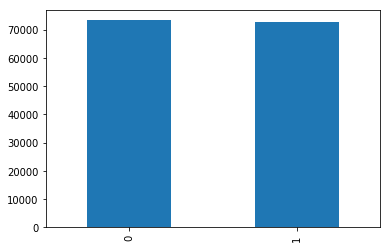

In [10]:
train_data['label'].value_counts().plot(kind = 'bar')

In [9]:
train_data.groupby("label").size().reset_index(name="count")

,label,count
0,0,73342
1,1,72841


In [11]:
train_data.isnull().values.any()

True

In [12]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [13]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [14]:
train_data = train_data.dropna(how="any")
train_data.isnull().values.any()

False

In [15]:
# 한글만 남기기
train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [16]:
# 한글만 남기는 과정에서 영어나 다른 문자로 작성된 리뷰는 ""으로 남게되니 제거하자
train_data["document"].replace("", np.nan, inplace=True)
train_data.isnull().sum()

id            0
document    391
label         0
dtype: int64

In [17]:
train_data = train_data.dropna(how="any")
len(train_data)

145791

In [18]:
test_data.drop_duplicates(subset=["document"], inplace=True)
test_data["document"] = test_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
test_data["document"].replace("", np.nan, inplace=True)
test_data = test_data.dropna(how="any")
len(test_data)

48852

### Tokenize

In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
len(stopwords)

18

In [21]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [24]:
x_train = []
for sentence in tqdm(train_data["document"]):
    temp_x = []
    temp_x = okt.morphs(sentence, stem=True)
    temp_x = [word for word in temp_x if not word in stopwords]
    x_train.append(temp_x)
len(x_train), x_train[0]

100%|██████████| 145791/145791 [13:00<00:00, 186.72it/s]


(145791, ['아', '더빙', '진짜', '짜증나다', '목소리'])

In [25]:
x_test = []
for sentence in tqdm(test_data["document"]):
    temp_x = []
    temp_x = okt.morphs(sentence, stem=True)
    temp_x = [word for word in temp_x if not word in stopwords]
    x_test.append(temp_x)
len(x_test), x_test[0]

100%|██████████| 48852/48852 [32:30<00:00, 25.04it/s]  


(48852, ['굳다', 'ㅋ'])

### 정수 인코딩

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
tokenizer.word_index["영화"]

1

In [27]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [28]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
vocab_size = total_cnt - rare_cnt + 2 # 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
print(f"Num of words: {vocab_size}")

Num of words: 19417


In [29]:
tokenizer = Tokenizer(vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test) # word > index로 변환
x_train[:2]

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20]]

In [30]:
y_train = np.array(train_data["label"])
y_test = np.array(test_data["label"])
y_train.shape, y_test.shape

((145791,), (48852,))